Loaded CIFAR-100 with shape: (50000, 32, 32, 3)
Total samples: 50000
Selected 15000 samples for t-SNE visualization
Subset contains 100 different classes
Extracting features with ResNet50...
Extracting features from 15000 images...
  Processed 1280/15000 images
  Processed 2560/15000 images
  Processed 3840/15000 images
  Processed 5120/15000 images
  Processed 6400/15000 images
  Processed 7680/15000 images
  Processed 8960/15000 images
  Processed 10240/15000 images
  Processed 11520/15000 images
  Processed 12800/15000 images
  Processed 14080/15000 images
Feature shape: (15000, 2048)
Applying PCA...
PCA explained variance ratio: 0.584
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 3.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 

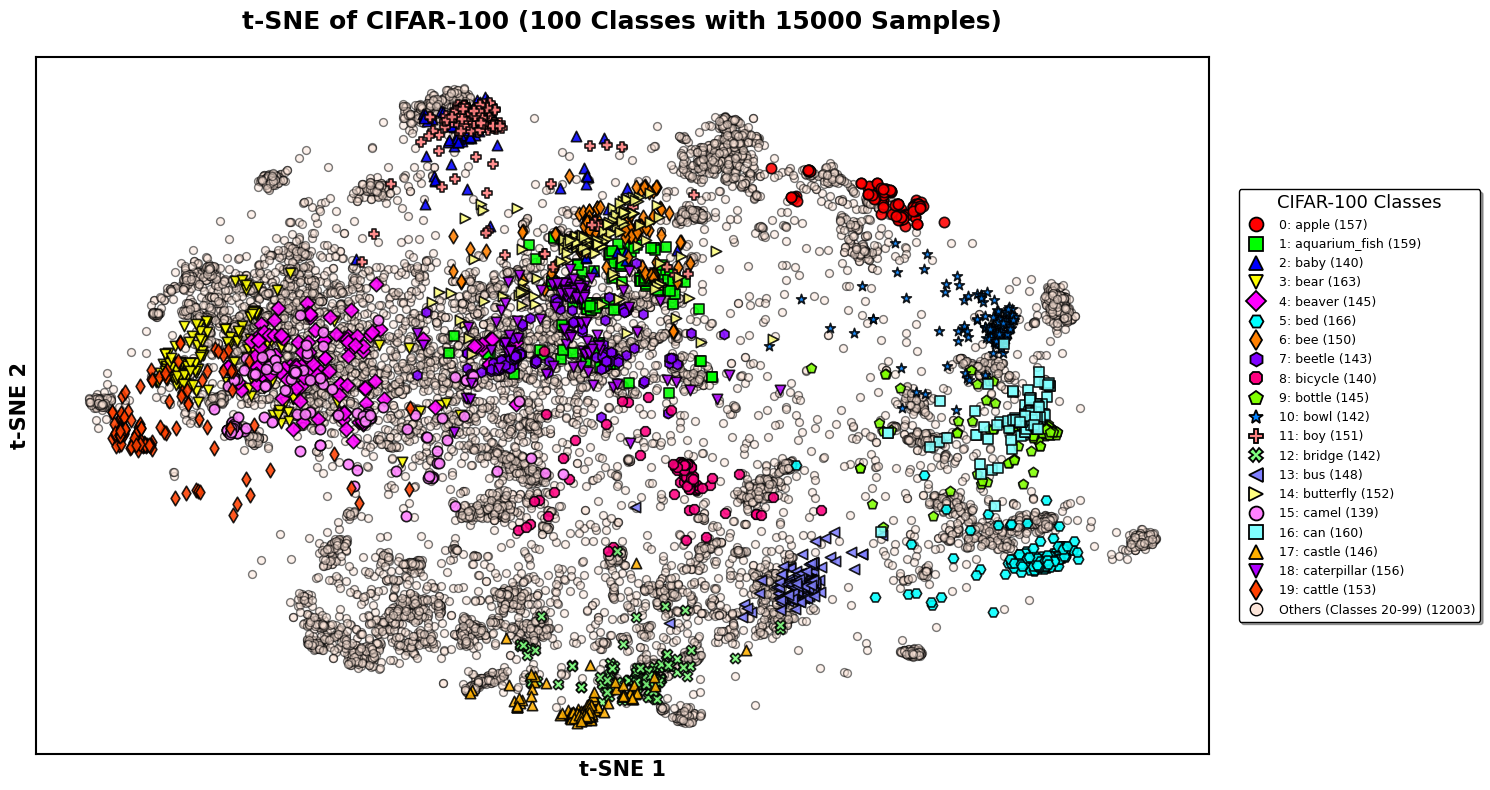

In [6]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.datasets import cifar100
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# CIFAR-100 class names (fine labels)
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# 1. Load CIFAR-100 data
(x_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
y_train = y_train.flatten()
print("Loaded CIFAR-100 with shape:", x_train.shape)
print("Total samples:", len(x_train))

# 2. Random sampling to select subset of points
def select_subset_random(x_data, y_data, n_samples=5000, random_state=42):
    """
    Randomly select n_samples from the dataset
    """
    np.random.seed(random_state)
    total_samples = len(x_data)
    
    if n_samples >= total_samples:
        print(f"Requested {n_samples} samples, but only {total_samples} available. Using all samples.")
        return x_data, y_data, np.arange(total_samples)
    
    # Random sampling
    indices = np.random.choice(total_samples, size=n_samples, replace=False)
    indices = np.sort(indices)  # Sort for reproducibility
    
    return x_data[indices], y_data[indices], indices

# Apply random sampling
n_samples = 15000  # Adjust this number based on your needs (speed vs. representation)
x_subset, y_subset, subset_indices = select_subset_random(x_train, y_train, n_samples=n_samples)
print(f"Selected {len(x_subset)} samples for t-SNE visualization")

# Print class distribution in subset
unique_classes, counts = np.unique(y_subset, return_counts=True)
print(f"Subset contains {len(unique_classes)} different classes")

# 3. Extract features using a pre-trained ResNet50
def extract_resnet_features(images, batch_size=256):
    model = ResNet50(include_top=False, pooling="avg", weights="imagenet", input_shape=(224, 224, 3))
    features = []
    n = images.shape[0]
    
    print(f"Extracting features from {n} images...")
    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size]
        # Resize and preprocess
        batch_resized = tf.image.resize(batch, (224, 224)).numpy()
        batch_prep = preprocess_input(batch_resized)
        batch_features = model.predict(batch_prep, verbose=0)
        features.append(batch_features)
        
        if (i // batch_size + 1) % 5 == 0:
            print(f"  Processed {min(i + batch_size, n)}/{n} images")
    
    features = np.concatenate(features, axis=0)
    return features

print("Extracting features with ResNet50...")
features = extract_resnet_features(x_subset.astype(np.float32))
print(f"Feature shape: {features.shape}")

# 4. PCA preprocessing (reduce to 50D for t-SNE)
print("Applying PCA...")
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# 5. Optimized t-SNE (with suggested params)
print("Running t-SNE...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=2000,
    early_exaggeration=12,
    random_state=42,
    metric='cosine',
    init='pca',
    verbose=1  # Show progress
)
tsne_embeddings = tsne.fit_transform(features_pca)
print("t-SNE completed!")


# 6. Enhanced post-processing
def enhance_tsne_clustering(tsne_emb, labels, enhancement_factor=2.0):
    """
    Enhance cluster separation by moving points away from global center
    """
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(tsne_emb)
    unique_labels = np.unique(labels)
    emb_enhanced = emb_scaled.copy()
    global_center = emb_scaled.mean(axis=0)
    
    for label in unique_labels:
        idx = (labels == label)
        if np.sum(idx) > 1:
            centroid = emb_scaled[idx].mean(axis=0)
            direction = centroid - global_center
            emb_enhanced[idx] += enhancement_factor * direction
    
    return emb_enhanced

enhanced_tsne = enhance_tsne_clustering(tsne_embeddings, y_subset, enhancement_factor=2.0)

def plot_tsne_with_solid_filled_edged_markers(embeddings, labels, title="t-SNE of CIFAR-100", save_path="tsne_cifar100.png"):
    import itertools
    FILLED_MARKERS =  [
    'o',  # Circle
    's',  # Square
    '^',  # Triangle_up
    'v',  # Triangle_down
    'D',  # Diamond
    'H',  # Hexagon2
    'd',  # Thin_diamond
    'h',  # Hexagon1
    '8',  # Octagon
    'p',  # Pentagon
    '*',  # Star
    'P',  # Plus (filled)
    'X',  # X (filled)
    '<',  # Triangle_left
    '>',  # Triangle_right
    'o','s','^','v',
    'd',  # Vertical line (not filled, but visible)
]

    BRIGHT_COLORS =[
        '#FF0000',  # Bright Red
        '#00FF00',  # Bright Green  
        '#0000FF',  # Bright Blue
        '#FFFF00',  # Bright Yellow
        '#FF00FF',  # Bright Magenta
        '#00FFFF',  # Bright Cyan
        '#FF8000',  # Bright Orange
        '#8000FF',  # Bright Purple
        '#FF0080',  # Hot Pink
        '#80FF00',  # Lime Green
        '#0080FF',  # Bright Sky Blue
        '#FF8080',  # Light Red
        '#80FF80',  # Light Green
        '#8080FF',  # Light Blue
        '#FFFF80',  # Light Yellow
        '#FF80FF',  # Light Magenta
        '#80FFFF',  # Light Cyan
        '#FFB000',  # Amber
        '#B000FF',  # Electric Purple
        '#FF4000',  # Red Orange
    ]
    
    OTHERS_COLOR = '#FCE5D9'
    plt.figure(figsize=(15, 8))
    plt.gca().set_facecolor('white')

    legend_elements = []
    num_classes = 20
    used_markers = list(itertools.islice(itertools.cycle(FILLED_MARKERS), num_classes + 1))

    for class_id in range(num_classes):
        mask = (labels == class_id)
        if np.sum(mask):
            marker = used_markers[class_id]
            color = BRIGHT_COLORS[class_id]
            plt.scatter(
                embeddings[mask, 0], embeddings[mask, 1],
                c=color, s=55, marker=marker, alpha=0.88,
                edgecolors='black', linewidths=1.2, label=None, zorder=3
            )
            legend_elements.append(
                plt.Line2D([0], [0], marker=marker, color='w',
                           markerfacecolor=color, markeredgecolor='black',
                           markersize=10, markeredgewidth=1.3,
                           label=f'{class_id}: {cifar100_classes[class_id]} ({np.sum(mask)})')
            )

    others_mask = labels >= num_classes
    if np.sum(others_mask):
        others_marker = used_markers[num_classes]
        plt.scatter(
            embeddings[others_mask, 0], embeddings[others_mask, 1],
            c=OTHERS_COLOR, s=32, marker=others_marker, alpha=0.52,
            edgecolors='black', linewidths=1.0, label=None, zorder=2
        )
        legend_elements.append(
            plt.Line2D([0], [0], marker=others_marker, color='w',
                       markerfacecolor=OTHERS_COLOR, markeredgecolor='black',
                       markersize=9, markeredgewidth=1.0,
                       label=f'Others (Classes 20-99) ({np.sum(others_mask)})')
        )

    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
               fontsize=9, frameon=True, fancybox=True, shadow=True,
               title="CIFAR-100 Classes", title_fontsize=13,
               edgecolor='black', facecolor='white')
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('t-SNE 1', fontsize=15, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=15, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

plot_tsne_with_solid_filled_edged_markers(enhanced_tsne, y_subset, 
                           f"t-SNE of CIFAR-100 (100 Classes with {n_samples} Samples)", save_path="tsne_cifar100.png")